In [ ]:
import os

from concurrent.futures import ProcessPoolExecutor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import uf3
from uf3.data.io import DataCoordinator
from uf3.data.composition import ChemicalSystem
from uf3.representation.bspline import BSplineBasis
from uf3.representation.process import BasisFeaturizer
from uf3.regression.least_squares import WeightedLinearModel

from uf3.representation import distances
from uf3.regression import least_squares
from uf3.util import plotting

# Setup

In [2]:
n_jobs = 8 # Maximum number of parallel processes for featurization

element_list = ["W"]
degree = 2 # include two-body interactions (pair potential)

r_min_map = {('W', 'W'): 1.5,}  # minimum distance cutoff (angstroms)
r_max_map = {('W', 'W'): 5.5,}  # maximum distance cutoff (angstroms)
resolution_map = {('W', 'W'): 12}  # number of knot intervals

regularization_params = dict(ridge_1b=1e-6,  # L2 (Ridge) regularization
                             ridge_2b=1e-8,  # L2 (Ridge) regularization
                             curve_2b=1e-8)  # Curvature regularization

# Initialize data coordinator and chemical system

In [3]:
data_coordinator = DataCoordinator()

chemical_system = ChemicalSystem(element_list=element_list,
                                 degree=degree)

# Load data from LAMMPS run directory

In [4]:
data_coordinator.dataframe_from_trajectory("w-14.xyz",
                                           prefix='dft')

df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [5]:
df_data.head()


,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1948,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.127,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1333,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1396,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142,[0.0],[0.0],[0.0],1.0


# Visualize partial radial distribution functions
### This can be a sanity check for specified interaction-specific cutoffs.

In [6]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
histograms = distances.summarize_distances(df_slice,
                                           chemical_system,
                                           min_peak_width=0.2)

100%|██████████| 1000/1000 [00:10<00:00, 98.82it/s]

('W', 'W') Lower bound: 1.920 angstroms
('W', 'W') Peaks (min width 0.2 angstroms): [5.22 6.9  9.42]


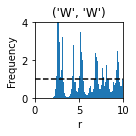

In [7]:
bar_width = histograms[1][1] - histograms[1][0]
pairs = chemical_system.interactions_map[2]
fig, ax = plt.subplots(1, len(pairs), figsize=(len(pairs)*2, 2))
if not isinstance(ax, (list, np.ndarray)):
    ax = [ax]
for i, pair in enumerate(pairs):
    ax[i].bar(histograms[1][:-1],
              histograms[0][pair],
              width=bar_width)
    ax[i].set_title(pair)
    ax[i].plot([0, 10], [1, 1], linestyle='--', color='k')
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel("r")
    ax[i].set_ylabel("Frequency")
fig.tight_layout()


# Initialize representation, regularizer, and model


In [8]:
bspline_config = BSplineBasis(chemical_system,
                               r_min_map=r_min_map,
                               r_max_map=r_max_map,
                               resolution_map=resolution_map)

representation = BasisFeaturizer(chemical_system,
                                bspline_config)

regularizer = bspline_config.get_regularization_matrix(
    **regularization_params)
fixed = bspline_config.get_fixed_tuples(values=0,
                                        one_body=False,
                                        upper_bounds=True,
                                        lower_bounds=False)

model = WeightedLinearModel(regularizer=regularizer,
                            fixed_tuples=fixed)

client = ProcessPoolExecutor(max_workers=n_jobs)

# Compute energy and force features using B-spline basis

In [9]:
n_batches = 16  # added granularity for more progress bar updates (optional).
df_features = representation.evaluate_parallel(df_data,
                                               client,
                                               n_jobs=n_jobs * n_batches)

100%|██████████| 128/128 [01:25<00:00,  1.56it/s]

In [10]:
df_features.tail()

y  n_W  ij_0  ij_1  ij_2      ij_3      ij_4  \
dft_9692 fz_130 -0.349308  0.0  -0.0  -0.0  -0.0 -0.284629  0.115201   
         fz_131  0.646192  0.0  -0.0  -0.0  -0.0  0.473734 -0.779015   
         fz_132 -1.066545  0.0  -0.0  -0.0  -0.0 -0.301764  0.980453   
         fz_133 -0.292102  0.0  -0.0  -0.0  -0.0  0.006905 -0.223910   
         fz_134  0.034134  0.0  -0.0  -0.0  -0.0 -0.058272 -0.024893   

                     ij_5      ij_6      ij_7      ij_8      ij_9     ij_10  \
dft_9692 fz_130  0.907442 -0.508149 -0.156850 -0.310577 -1.730358  4.005582   
         fz_131  0.625148 -1.844884  1.336873  0.700906  2.979020 -7.848901   
         fz_132 -2.913931  5.116118 -1.887448 -2.466755 -0.748139  5.771566   
         fz_133 -0.172881  1.404027 -0.584533 -0.586029 -1.418083  3.179218   
         fz_134  0.272448  0.271886 -1.339522  0.998410  0.665213 -1.289444   

                     ij_11      ij_12      ij_13      ij_14  
dft_9692 fz_130  -4.991529  10.987032  -7.809375  -0.223789  
         fz_131  10.472510  -9.255821 -11.073421  14.213852  
         fz_132 -11.883671   4.507288  19.810635 -15.984351  
         fz_133  -5.733854   1.447427  14.131168 -11.449455  
         fz_134  -2.316576  10.336306   7.781168 -15.296725

# Fit with 20% of the data, using preset training set
### Weighing energies and forces with kappa = 0.9

In [11]:
kappa = 0.9  # energy-force weighting parameter between 0 and 1.

np.random.seed(8)
n_train = int(len(df_data) * 0.2)
training_indices = np.random.choice(np.arange(len(df_data)), 
                                    n_train,
                                    replace=False)
training_keys = np.take(df_data.index, training_indices)
testing_indices = np.setdiff1d(np.arange(len(df_data), dtype=int), training_indices)
testing_keys = np.take(df_data.index, testing_indices)

df_train = df_features.loc[training_keys]
df_test = df_features.loc[testing_keys]
x, y, w = representation.get_training_tuples(df_train,
                                             kappa,
                                             data_coordinator)

In [12]:
model.fit(x, y, weights=w)

In [13]:
c_2 = model.coefficients[bspline_config.partition_sizes[0]:]
c_2 = least_squares.postprocess_coefficients(c_2)
model.coefficients[bspline_config.partition_sizes[0]:] = c_2

# Evaluate Energy and Forces with model

In [14]:
# Evaluate
x_test, y_test, w_cond = representation.get_training_tuples(df_test,
                                                            0,
                                                            data_coordinator)
# slice entries corresponding to energies per atom
s_e = df_data.loc[testing_keys][data_coordinator.size_key]
x_e = np.divide(x_test[w_cond == 0].T, s_e.values).T
y_e = y_test[w_cond == 0] / s_e.values
# slice entries corresponding to forces
x_f = x_test[w_cond > 0]
y_f = y_test[w_cond > 0]
# predict with solution
p_e = model.predict(x_e)  # energy per atom
p_f = model.predict(x_f)

# Compute root-mean-square error

In [15]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print("Energy RMSE:", rmse_e, "eV/atom")
print("Forces RMSE:", rmse_f, "eV/angstrom")

Energy RMSE: 0.025859622432284173 eV/atom
Forces RMSE: 0.3099057521755056 eV/angstrom


# Arrange solution into pair-interaction potentials

In [16]:
split_indices = np.cumsum(bspline_config.partition_sizes)[:-1]
solutions_list = np.array_split(model.coefficients,
                                split_indices)
solutions = {element: value for element, value
             in zip(chemical_system.element_list, solutions_list[0])}
for i, pair in enumerate(chemical_system.interactions_map[2]):
    solutions[pair] = solutions_list[i + 1]

In [17]:
for key, value in solutions.items():
    if isinstance(value, (float, np.floating)):
        print("{0}: {1:.6f}".format(key, value))
    else:
        print("{}: vector".format(key), value.shape)

W: -7.666735
('W', 'W'): vector (15,)


# Plot results


<ipython-input-18-77cc92652f15>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


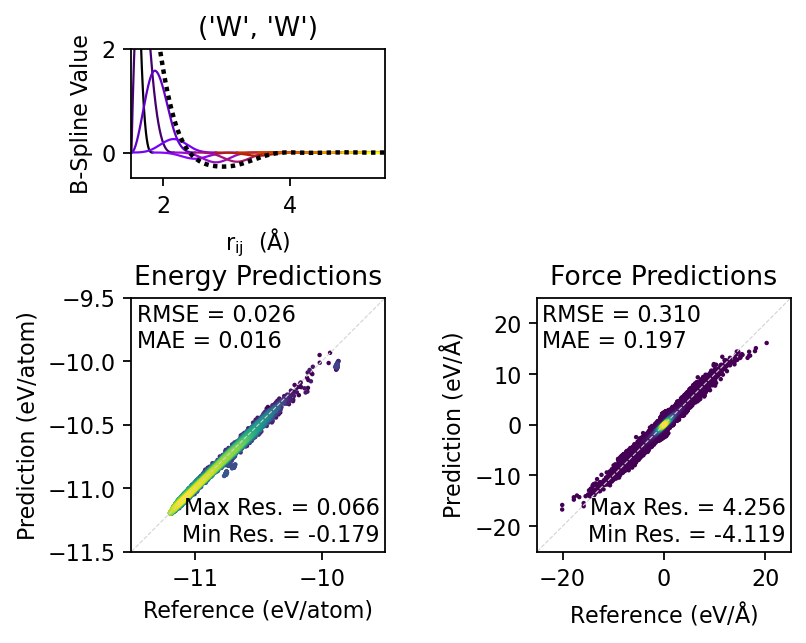

In [18]:
y_min = -1
y_max = 2
ENERGY_UNITS = "eV/atom"
FORCE_UNITS = "eV/$\mathrm{\AA}$"

fig = plt.figure(figsize=(7.48, 4), dpi=160, facecolor='white')
gs = fig.add_gridspec(ncols=3, nrows=2,
                      width_ratios=[1, 1, 1],
                      height_ratios=[0.5, 1])

for i, pair in enumerate(chemical_system.interactions_map[2]):
    ax = fig.add_subplot(gs[0, i])
    r_min = r_min_map[pair]
    r_max = r_max_map[pair]
    knot_sequence = representation.knots_map[pair]
    coefficients = solutions[pair]
    plotting.visualize_splines(coefficients,
                               knot_sequence,
                               ax=ax,)
    ax.set_ylabel('B-Spline Value')
    ax.set_xlabel('$\mathrm{r_{ij}~~(\AA)}$')
    ax.set_title(pair)
    ax.set_ylim(-0.5, 2)
ax2 = fig.add_subplot(gs[1, 0])
plotting.density_scatter(y_e, p_e, ax=ax2, units=ENERGY_UNITS)
ax2.set_xlabel('Reference ({})'.format(ENERGY_UNITS))
ax2.set_ylabel('Prediction ({})'.format(ENERGY_UNITS))

ax3 = fig.add_subplot(gs[1, 1])
plotting.density_scatter(y_f, 
                         p_f, 
                         ax=ax3, 
                         units=FORCE_UNITS, 
                         subset_threshold=1000)
ax3.set_xlabel('Reference ({})'.format(FORCE_UNITS))
ax3.set_ylabel('Prediction ({})'.format(FORCE_UNITS))

ax2.set_title('Energy Predictions')
ax3.set_title('Force Predictions')
fig.subplots_adjust(left=0.1, right=0.99,
                    bottom=0.15, top=0.94,
                    wspace=0.6, hspace=0.6)
fig.show()


# Export tabulated potentials

In [ ]:
from uf3.forcefield import lammps

In [19]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             grid=1000,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
table_name = os.path.join("table_test", "W.table")
with open(table_name, "w") as f:
    f.write(combined_text)

# Compute energy, forces, stress with UFCalculator

In [ ]:
from uf3.forcefield import calculator

In [20]:
calc = calculator.UFCalculator(bspline_config, model)

geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: -129.91293531740013
Stresses (numerical): [-0.0543753  -0.03638182 -0.01470901  0.00238862 -0.01620332 -0.03222746]
Forces:
 [[ 3.26613860e-01 -6.91642291e+00  6.07400412e-01]
 [ 1.23419228e+00  4.26123679e-01 -5.86352943e-01]
 [-1.37832150e+00 -1.42765610e+00 -3.98962340e-01]
 [-1.74115341e+00  5.31758292e+00 -3.73344170e-01]
 [ 8.05222904e-01  2.22389485e+00  1.09754810e+00]
 [ 1.88088758e+00 -2.22025148e+00 -7.90118201e-01]
 [ 2.30380310e+00  1.54378719e+00 -7.34143396e-01]
 [-1.42987408e+00 -6.63984128e-01  1.02735536e+00]
 [-2.19003903e+00 -2.42263636e-03  6.94168162e-02]
 [ 3.07377404e-01  5.29370994e+00 -4.41367907e-02]
 [ 1.81183116e+00 -3.30984614e+00 -2.38454179e-01]
 [-1.93054028e+00 -2.64515182e-01  3.63791324e-01]]
Max force: 6.9164229091479585


# Compare with UFLammps calculator

In [21]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))
del calc

Energy: -37.9121180897919
Stresses (numerical): [-0.0543752  -0.03638209 -0.01470938  0.0023884  -0.01620334 -0.03222738]
Forces:
 [[-3.26614206e-01  6.91642289e+00 -6.07400685e-01]
 [-1.23419291e+00 -4.26123503e-01  5.86353877e-01]
 [ 1.37832214e+00  1.42765467e+00  3.98961785e-01]
 [ 1.74115484e+00 -5.31758224e+00  3.73341672e-01]
 [-8.05223999e-01 -2.22389434e+00 -1.09754948e+00]
 [-1.88088985e+00  2.22025108e+00  7.90116544e-01]
 [-2.30380391e+00 -1.54378347e+00  7.34144117e-01]
 [ 1.42987574e+00  6.63982768e-01 -1.02735365e+00]
 [ 2.19004002e+00  2.42184887e-03 -6.94152320e-02]
 [-3.07380450e-01 -5.29373161e+00  4.41180043e-02]
 [-1.81182844e+00  3.30987011e+00  2.38474895e-01]
 [ 1.93054101e+00  2.64511782e-01 -3.63791849e-01]]
Max force: 6.916422891725154


# Relax with UFLammps calculator

In [22]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
calc.relax(geom)
print('Relaxation Steps:', calc.results['nsteps'])
geom.calc = calc
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
lammps_forces = geom.get_forces()
print("Forces:\n", lammps_forces)
print("Max force:", np.max(lammps_forces))
del calc

Relaxation Steps: 93
Energy: -41.23010080514103
Stresses (numerical): [-0.03376374  0.00191698  0.0318193   0.00768406 -0.01794595 -0.04558064]
Forces:
 [[ 0.00528491 -0.00246796  0.00235554]
 [-0.0008847  -0.00878648  0.00373691]
 [-0.00228546 -0.00486096  0.00216438]
 [ 0.00122039 -0.00128789  0.00184671]
 [ 0.00845143 -0.00159939  0.00195616]
 [-0.00022463  0.0077283  -0.00100959]
 [-0.00286689 -0.00321598 -0.00167861]
 [ 0.00632936  0.00285896  0.00023215]
 [-0.00193798 -0.00077773 -0.00173439]
 [-0.0055369   0.00645764 -0.00301832]
 [-0.00636335 -0.00251386 -0.00291591]
 [-0.00118617  0.00846536 -0.00193502]]
Max force: 0.008465359163967
